In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# ตั้งค่ากราฟให้สวยงามและอ่านง่าย
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'Tahoma' # หรือใส่ฟอนต์ไทยถ้ามี
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
def load_and_fix_data():
    # 1. โหลดข้อมูลดิบ
    df_gold = pd.read_csv('gold_history_updated.csv')
    df_btc = pd.read_csv('bitcoin_history_updated.csv')
    df_fx = pd.read_csv('exchange_rate_updated.csv')
    df_oil = pd.read_csv('petroleum_data_updated.csv')

    # ---------------------------------------------------------
    # จัดการวันที่ (Date Handling)
    # ---------------------------------------------------------
    # Gold: ใช้คอลัมน์ datetime (ถ้ามี) หรือแปลง date
    if 'datetime' in df_gold.columns:
        df_gold['date'] = pd.to_datetime(df_gold['datetime'], errors='coerce')
    else:
        df_gold['date'] = pd.to_datetime(df_gold['date'], dayfirst=True, errors='coerce')
        
    df_btc['date'] = pd.to_datetime(df_btc['date'])
    df_fx['date'] = pd.to_datetime(df_fx['date'])
    
    # Oil: แปลง 2023-01 เป็น 2023-01-01
    df_oil['date'] = pd.to_datetime(df_oil['period'].astype(str) + '-01', errors='coerce')

    # ---------------------------------------------------------
    # คัดเลือกคอลัมน์ (Feature Selection)
    # ---------------------------------------------------------
    # Gold
    col_gold = 'gold_bar_sell' if 'gold_bar_sell' in df_gold.columns else 'gold_sell'
    df_gold = df_gold[['date', col_gold]].rename(columns={col_gold: 'gold'})
    
    # FX (USD/THB)
    df_fx = df_fx[['date', 'mid_rate']].rename(columns={'mid_rate': 'fx'})
    
    # Oil (ใช้ Diesel U.S. เป็นตัวแทนราคาน้ำมันโลก)
    df_oil = df_oil[df_oil['product-name'].str.contains('No 2 Diesel', na=False) & (df_oil['area-name'] == 'U.S.')]
    df_oil = df_oil[['date', 'value']].rename(columns={'value': 'oil'})

    # ---------------------------------------------------------
    # 🛠️ FIX BITCOIN: แปลง USD -> THB
    # ---------------------------------------------------------
    # ต้องรวม FX เข้าไปก่อนเพื่อใช้คูณ
    # ทำ FX ให้เป็นรายวัน (ffill)
    fx_daily = df_fx.set_index('date').resample('D').ffill().reset_index()
    
    # รวม BTC กับ FX
    df_btc_merge = pd.merge(df_btc, fx_daily, on='date', how='left')
    df_btc_merge['fx'] = df_btc_merge['fx'].ffill().bfill() # เติมค่า FX ที่หาย
    
    # Logic: ถ้าราคา < 500,000 บาท แสดงว่าเป็น USD -> จับคูณ FX
    # (Bitcoin ไม่เคยต่ำกว่า 5 แสนบาท มาตั้งแต่ปี 2021)
    mask_usd = df_btc_merge['btc_price'] < 500000 
    df_btc_merge.loc[mask_usd, 'btc_price'] = df_btc_merge.loc[mask_usd, 'btc_price'] * df_btc_merge.loc[mask_usd, 'fx']
    
    # ได้ราคา BTC ที่ถูกต้องแล้ว
    df_btc_clean = df_btc_merge[['date', 'btc_price']].rename(columns={'btc_price': 'btc'})

    # ---------------------------------------------------------
    # รวมทุกตาราง (Merge All)
    # ---------------------------------------------------------
    dfs = [df_gold, df_btc_clean, df_fx, df_oil]
    df_final = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), dfs)
    
    # เรียงวันที่และเติมข้อมูล (Forward Fill)
    df_final = df_final.sort_values('date').ffill()
    
    # ตัดเฉพาะปี 2023 - ปัจจุบัน
    df_final = df_final[df_final['date'] >= '2023-01-01'].dropna()
    
    return df_final

# เรียกใช้ฟังก์ชัน
df = load_and_fix_data()
print("✅ ข้อมูลพร้อมแล้ว! (ตัวอย่าง 5 แถวแรก):")
print(df.head())

✅ ข้อมูลพร้อมแล้ว! (ตัวอย่าง 5 แถวแรก):
        date     gold            btc       fx    oil
2 2023-01-02  30350.0  554547.845018  33.2294  4.576
3 2023-01-03  30450.0  554261.739884  33.2294  4.576
4 2023-01-04  30450.0  560355.347256  33.2294  4.576
5 2023-01-05  30250.0  559474.768156  33.2294  4.576
6 2023-01-06  30150.0  563303.791918  33.2294  4.576


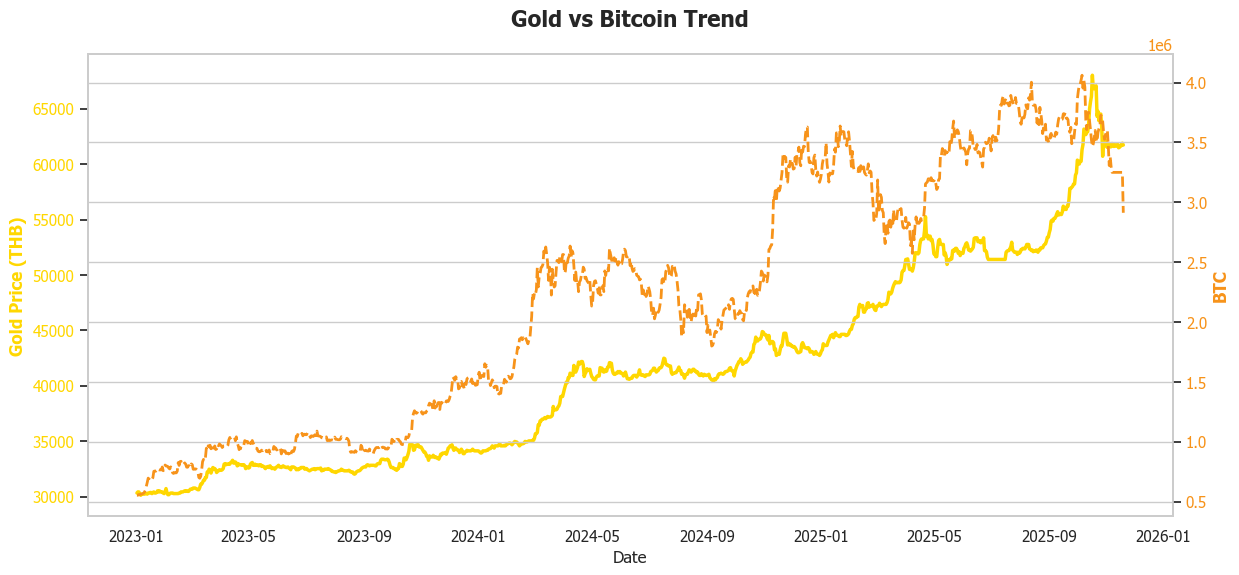

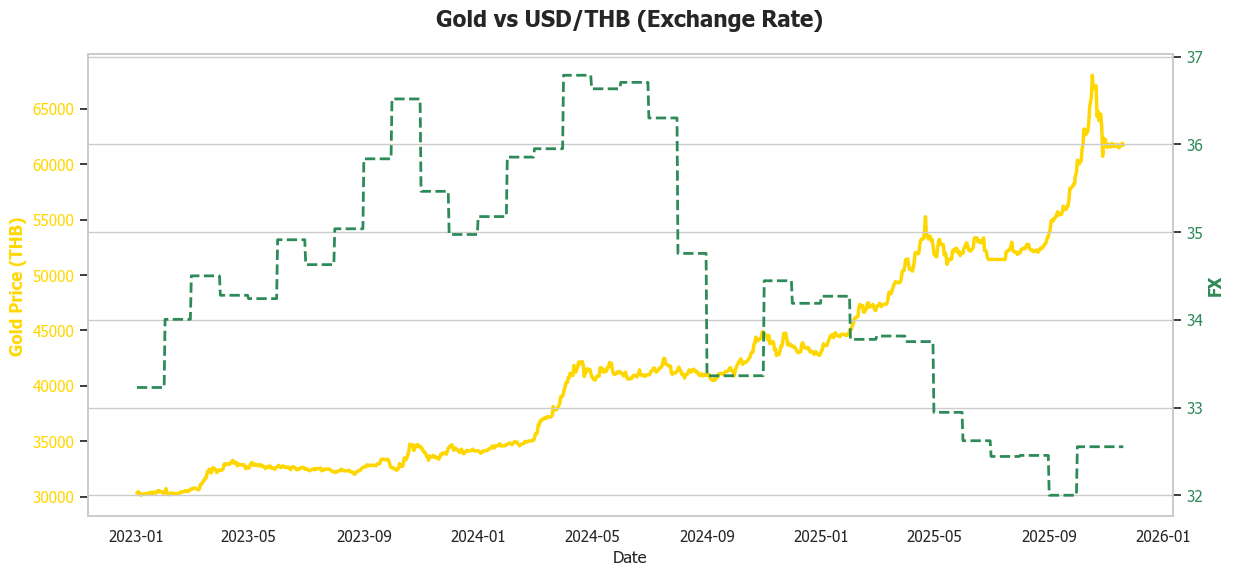

In [10]:
def plot_trend_comparison(data, col_primary, col_secondary, title, color2='blue'):
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # แกนซ้าย (Primary): ราคาทองคำ
    color1 = '#FFD700' # สีทอง
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Gold Price (THB)', color=color1, fontsize=12, fontweight='bold')
    ax1.plot(data['date'], data[col_primary], color=color1, linewidth=2.5, label='Gold Price')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(False) # ปิด grid แกนซ้ายเพื่อความสะอาด

    # แกนขวา (Secondary): ตัวแปรคู่เทียบ
    ax2 = ax1.twinx() 
    ax2.set_ylabel(col_secondary.upper(), color=color2, fontsize=12, fontweight='bold')
    ax2.plot(data['date'], data[col_secondary], color=color2, linewidth=2, linestyle='--', label=col_secondary.upper())
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # ตกแต่ง
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.savefig('plot_trend_compare.png')
    plt.show()

# 1. Gold vs Bitcoin (คู่หูขาขึ้น)
plot_trend_comparison(df, 'gold', 'btc', 'Gold vs Bitcoin Trend', color2='#F7931A') # สีส้ม Bitcoin

# 2. Gold vs USD/THB (ปัจจัยค่าเงิน)
plot_trend_comparison(df, 'gold', 'fx', 'Gold vs USD/THB (Exchange Rate)', color2='#2E8B57') # สีเขียว

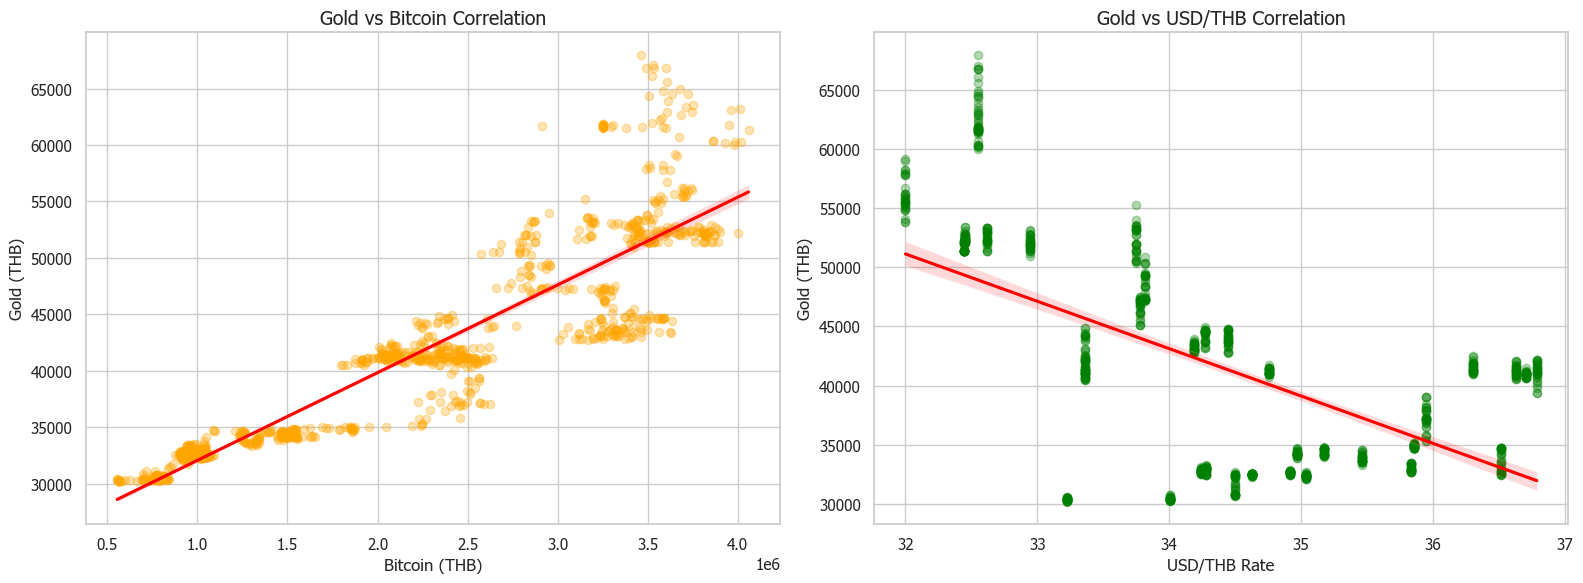

In [11]:
# สร้างพื้นที่กราฟ 1 แถว 2 รูป
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Gold vs Bitcoin
sns.regplot(x='btc', y='gold', data=df, ax=ax1, 
            scatter_kws={'alpha':0.3, 'color':'orange'}, line_kws={'color':'red'})
ax1.set_title('Gold vs Bitcoin Correlation', fontsize=14)
ax1.set_xlabel('Bitcoin (THB)')
ax1.set_ylabel('Gold (THB)')

# 2. Gold vs FX (ค่าเงินบาท)
sns.regplot(x='fx', y='gold', data=df, ax=ax2, 
            scatter_kws={'alpha':0.3, 'color':'green'}, line_kws={'color':'red'})
ax2.set_title('Gold vs USD/THB Correlation', fontsize=14)
ax2.set_xlabel('USD/THB Rate')
ax2.set_ylabel('Gold (THB)')

plt.tight_layout()
plt.savefig('gold_btc_fx.png')
plt.show()